In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import correlate
from scipy.ndimage import shift as roll

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from ezyrb import POD, RBF, Database, Snapshot, Parameter, Linear, GPR
from ezyrb import ReducedOrderModel as ROM

In [3]:
# Define the Gaussian function
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
# Define traveling wave function
def wave(t, res=256):
    x = np.linspace(0, 11, res)
    return x, gaussian(x, t, 0.19).T

In [4]:
# Generate parameters and database snapshots
n_params = 101
params = np.linspace(0.75, 10.25, n_params).reshape(-1, 1)
pod = POD(rank=1)  
rbf = RBF(kernel='gaussian')
gpr = GPR()

linear = Linear(fill_value=0)
db = Database()

for param in params:
    space, values = wave(param)
    snap = Snapshot(values=values.T, space=space)
    db.add(Parameter(param), snap)
    
print("Snapshot shape : ", db.snapshots_matrix.shape)
print("Parameter shape : ", db.parameters_matrix.shape)

Snapshot shape :  (101, 256)
Parameter shape :  (101, 1)


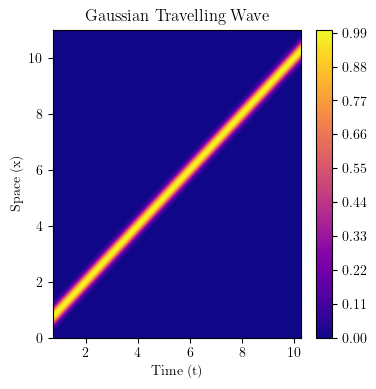

In [5]:
space, _ = wave(params)
snapshot_matrix = []

for param in params:
    _, values = wave(param)
    snapshot_matrix.append(values)

snapshot_matrix = np.array(snapshot_matrix)  

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 10,  # Sets font size for all elements
})

plt.figure(figsize=(4, 4))
X, Y = np.meshgrid(params, space)  
contour = plt.contourf(X, Y, snapshot_matrix.T, levels=100, vmin=0, vmax=1, cmap="plasma")
plt.colorbar(contour)
plt.xlabel("Time (t)")
plt.ylabel("Space (x)")
plt.title("Gaussian Travelling Wave")
plt.show()

In [6]:
# Define indices for 50-50 split
n_params = len(params)
train_end = int(0.5 * n_params)             
test_end = int(0.5 * n_params)              
# Split the parameters
train_params = params[:train_end]           # First 50% for training
test_params = params[train_end:]            # Later 50% for testing

db_train = Database()
db_test = Database()

# Populate train and test databases
for param in train_params:
    space, values = wave(param)
    snap = Snapshot(values=values.T, space=space)
    db_train.add(Parameter(param), snap)

for param in test_params:
    space, values = wave(param)
    snap = Snapshot(values=values.T, space=space)
    db_test.add(Parameter(param), snap)

print("Training set snapshot shape:", db_train.snapshots_matrix.shape)
print("Training set parameter shape:", db_train.parameters_matrix.shape)

print("Testing set snapshot shape:", db_test.snapshots_matrix.shape)
print("Testing set parameter shape:", db_test.parameters_matrix.shape)

Training set snapshot shape: (50, 256)
Training set parameter shape: (50, 1)
Testing set snapshot shape: (51, 256)
Testing set parameter shape: (51, 1)


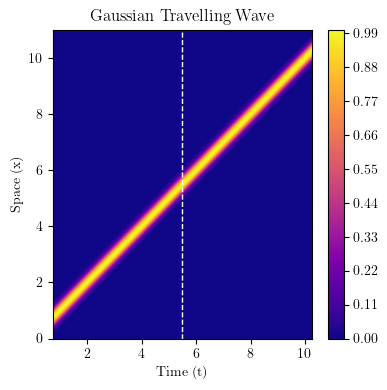

In [7]:
plt.figure(figsize=(4, 4))
X, Y = np.meshgrid(params, space)  # params (time) along x-axis, space (x) along y-axis
contour = plt.contourf(X, Y, snapshot_matrix.T, levels=100, vmin=0, vmax=1, cmap="plasma")
plt.axvline(x=params[train_end], color='white', linestyle='--', linewidth=1)  # Train/Validation Split
plt.ylabel("Space (x)")
plt.xlabel("Time (t)")
plt.title("Gaussian Travelling Wave")
plt.xticks()
plt.yticks()
plt.colorbar(contour).ax.tick_params() 
plt.tight_layout()
plt.show()

In [8]:
training_snapshots_matrix = np.array(db_train.snapshots_matrix)
training_parameters_matrix = np.array(db_train.parameters_matrix)

reference_index = int(len(db_train.parameters_matrix)/2 - 1)
reference_wave = training_snapshots_matrix[reference_index]

shifts = []
registered_waves = []
for i, wave in enumerate(training_snapshots_matrix):
    # Calculate the optimal shift using cross-correlation between the reference wave and the training snapshots
    correlation = correlate(reference_wave, wave, mode='full')
    shift = correlation.argmax() - (len(reference_wave) - 1)      # Calculate the shift
    registered_wave = roll(wave, shift)                           # Apply the shift to the current wave
    registered_waves.append(registered_wave)
    shifts.append(shift)
registered_waves = np.array(registered_waves)
print("Registered Snapshot shape :", registered_waves.shape)

Registered Snapshot shape : (50, 256)


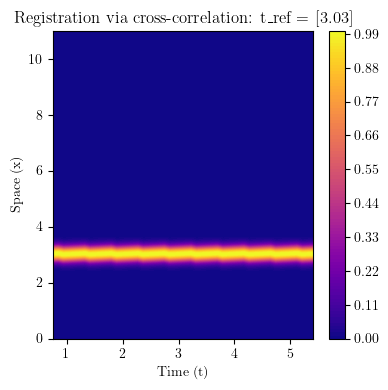

In [9]:
registered_waves_clipped = np.clip(registered_waves, 0, None)

plt.figure(figsize=(4, 4))
X, Y = np.meshgrid(train_params, space)
contour = plt.contourf(X, Y, registered_waves_clipped.T, levels=100, cmap="plasma", vmin = 0, vmax = 1)
plt.ylabel("Space (x)")
plt.xlabel("Time (t)")
plt.xticks()
plt.yticks()
plt.colorbar(contour).ax.tick_params()
plt.tight_layout()
plt.title(f"Registration via cross-correlation: t_ref = {train_params[reference_index]}")
plt.tight_layout()
plt.show()

Registered Train Snapshot shape :  (50, 256)
Registered Parameter shape :  (50, 1)


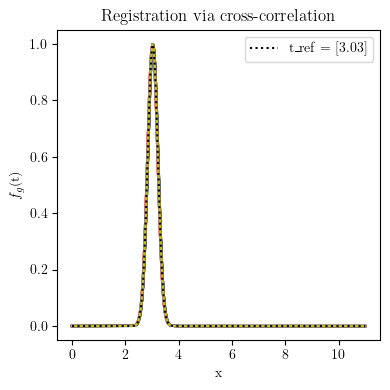

In [10]:
registered_train_db = Database()

for i, param in enumerate(train_params):
    registered_values = registered_waves[i]  # Get the registered wave corresponding to the parameter
    align = Snapshot(values=registered_values, space=space)
    registered_train_db.add(Parameter(param), align)
print("Registered Train Snapshot shape : ", registered_train_db.snapshots_matrix.shape)
print("Registered Parameter shape : ", registered_train_db.parameters_matrix.shape)

plt.figure(figsize=(4, 4))
for i, registered_wave in enumerate(registered_waves[1:], start=1):
    plt.plot(space, registered_wave)
plt.plot(space, reference_wave, label = f"t_ref = {db_train.parameters_matrix[reference_index]}", color='black', linestyle='dotted')
plt.title(f"Registration via cross-correlation")
plt.ylabel('$f_{g}$(t)')
plt.xlabel('x')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#%% Construct ROM
rom = ROM(database=registered_train_db, reduction=pod, approximation=rbf)
rom.fit()

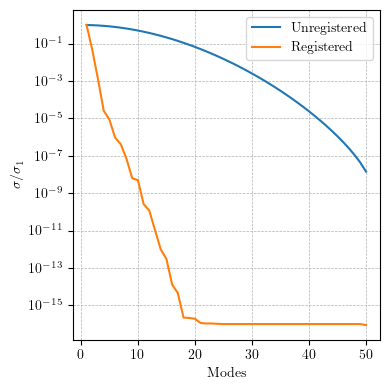

In [12]:
U, s = np.linalg.svd(db_train.snapshots_matrix, full_matrices=False)[:2]
N_modes = np.linspace(1, len(s), len(s))

U_shifted, s_shifted = np.linalg.svd(registered_train_db.snapshots_matrix, full_matrices=False)[:2]
N_modes_shifted = np.linspace(1, len(s_shifted), len(s_shifted))

plt.figure(figsize=(4,4))
plt.plot(N_modes, s/np.max(s), label='Unregistered', alpha=1)
plt.plot(N_modes_shifted, s_shifted/np.max(s_shifted), label='Registered', alpha=1)
plt.ylabel(r'$ \sigma/\sigma_{1}$')
plt.xlabel('Modes')
plt.yscale("log")  # Logarithmic scale on the y-axis
plt.grid(True, which="both", axis="both", linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

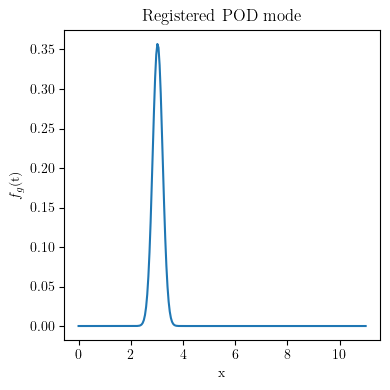

In [13]:
modes = pod.modes
plt.figure(figsize=(4,4))
plt.plot(space, modes*-1)
plt.ylabel('$f_{g}$(t)') 
plt.xlabel('x')
plt.title("Registered POD mode")
plt.tight_layout()
plt.show()

In [14]:
X = train_params.reshape(-1, 1)       
y = np.array(shifts)                 

degree = 1 
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

def predict_shift(parameter):
    param_poly = poly_features.transform(np.array([[parameter]]))
    predicted_shift = model.predict(param_poly)
    return predicted_shift[0] 

In [15]:
#%% Online : All the parameter 
pred_all = rom.predict(db.parameters_matrix)
print(db.parameters_matrix.shape)
print("Predicted snapshots at reference position shape:", pred_all.snapshots_matrix.shape )

(101, 1)
Predicted snapshots at reference position shape: (101, 256)


In [16]:
#%% Predict shifts for all training parameters
pred_all_shifts = []

for param in db.parameters_matrix.flatten():
    predicted_all_shift = predict_shift(param)
    pred_all_shifts.append(predicted_all_shift)
pred_all_shifts = np.array(pred_all_shifts)
print("Predicted snapshots at reference position shape:", pred_all.snapshots_matrix.shape )
print("Predicted shifts shape for Validation set:", pred_all_shifts.shape)

pred_all_shifts = np.array(pred_all_shifts) 
pred_all_waves = []
for i, registered_wave in enumerate(pred_all.snapshots_matrix):
    original_wave = roll(registered_wave, -pred_all_shifts[i])  
    pred_all_waves.append(original_wave)
pred_all_waves = np.array(pred_all_waves)
print("Revirted Extrapolation waves shape:", pred_all_waves.shape)

Predicted snapshots at reference position shape: (101, 256)
Predicted shifts shape for Validation set: (101,)
Revirted Extrapolation waves shape: (101, 256)


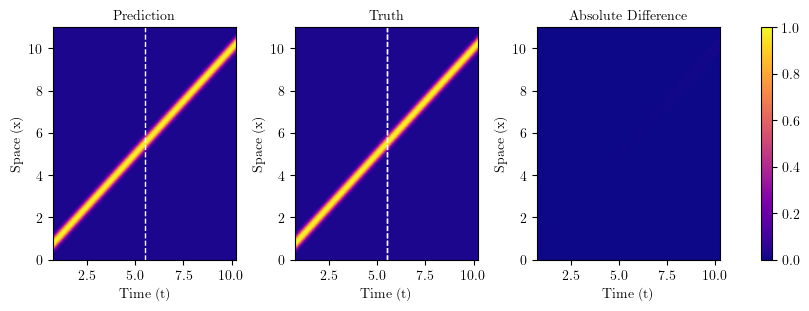

In [17]:
pred_all_waves_clipped = np.clip(pred_all_waves, 0, None)
absolute_difference = np.abs(pred_all_waves_clipped - snapshot_matrix)

fig, axes = plt.subplots(1, 3, figsize=(8, 3), constrained_layout=True)
font_size = 10
cmap = "plasma"
norm = plt.Normalize(vmin=0, vmax=1)

X1, Y1 = np.meshgrid(params, space) 
contour1 = axes[0].contourf(X1, Y1, pred_all_waves_clipped.T, levels=20, cmap=cmap, norm=norm)
axes[0].axvline(x=params[train_end], color='white', linestyle='--', linewidth=1)  
axes[0].set_xlabel("Time (t)", fontsize=font_size)
axes[0].set_ylabel("Space (x)", fontsize=font_size)
axes[0].set_title("Prediction", fontsize=font_size)
axes[0].tick_params(axis='both', labelsize=font_size)

X2, Y2 = np.meshgrid(params, space)  
contour2 = axes[1].contourf(X2, Y2, snapshot_matrix.T, levels=20, cmap=cmap, norm=norm)
axes[1].axvline(x=params[train_end], color='white', linestyle='--', linewidth=1)  
axes[1].set_xlabel("Time (t)", fontsize=font_size)
axes[1].set_ylabel("Space (x)", fontsize=font_size)
axes[1].set_title("Truth", fontsize=font_size)
axes[1].tick_params(axis='both', labelsize=font_size)

X3, Y3 = np.meshgrid(params, space) 
contour3 = axes[2].contourf(X3, Y3, absolute_difference.T, levels=20, cmap=cmap, norm=norm)
axes[1].axvline(x=params[train_end], color='white', linestyle='--', linewidth=1)  
axes[2].set_xlabel("Time (t)", fontsize=font_size)
axes[2].set_ylabel("Space (x)", fontsize=font_size)
axes[2].set_title("Absolute Difference", fontsize=font_size)
axes[2].tick_params(axis='both', labelsize=font_size)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical', shrink=1)
cbar.ax.tick_params(labelsize=font_size)
plt.show()

In [18]:
#%% Online : Testing dataset
pred_val = rom.predict(db_test.parameters_matrix)  # Prediction for test parameters
pred_val_shifts = []

for param in db_test.parameters_matrix:
    param = param.flatten()[0]              
    predicted_shift = predict_shift(param)
    pred_val_shifts.append(predicted_shift)
pred_val_shifts = np.array(pred_val_shifts)
print("Predicted snapshots at reference position shape:", pred_val.snapshots_matrix.shape )
print("Predicted shifts shape for Validation set:", pred_val_shifts.shape)

# Revert the shifts applied to each registered wave, to restore the original waves
pred_val_shifts = np.array(pred_val_shifts)  # Convert all shifts to integers
pred_val_waves = []
for i, registered_wave in enumerate(pred_val.snapshots_matrix):
    original_wave = roll(registered_wave, -pred_val_shifts[i])  # Shift using integer values
    pred_val_waves.append(original_wave)
pred_val_waves = np.array(pred_val_waves)
print("Reverted waves shape:", pred_val_waves.shape)

pred_val_errors = np.linalg.norm(pred_val_waves - db_test.snapshots_matrix, 
                            axis=1) / np.linalg.norm(db_test.snapshots_matrix, axis=1)
pred_val_mean = np.mean(pred_val_errors)

Predicted snapshots at reference position shape: (51, 256)
Predicted shifts shape for Validation set: (51,)
Reverted waves shape: (51, 256)


In [19]:
#%% Online : Training dataset
pred_train = rom.predict(db_train.parameters_matrix)  # Prediction for train parameters
pred_train_shifts = []
for param in db_train.parameters_matrix.flatten():  
    predicted_shift = predict_shift(param)
    pred_train_shifts.append(predicted_shift)
pred_train_shifts = np.array(pred_train_shifts)

#%% Revert the shifts applied to each registered wave, to get back in physical coordinates
pred_train_shifts = np.array(pred_train_shifts) 
pred_train_waves = []
for i, registered_wave in enumerate(pred_train.snapshots_matrix):  
    original_wave = roll(registered_wave, -pred_train_shifts[i])  
    pred_train_waves.append(original_wave)
pred_train_waves = np.array(pred_train_waves)
print("Reverted waves shape:", pred_train_waves.shape)

pred_train_errors = np.linalg.norm(pred_train_waves - db_train.snapshots_matrix, 
                            axis=1) / np.linalg.norm(db_train.snapshots_matrix, axis=1)
pred_train_mean = np.mean(pred_train_errors)

Reverted waves shape: (50, 256)


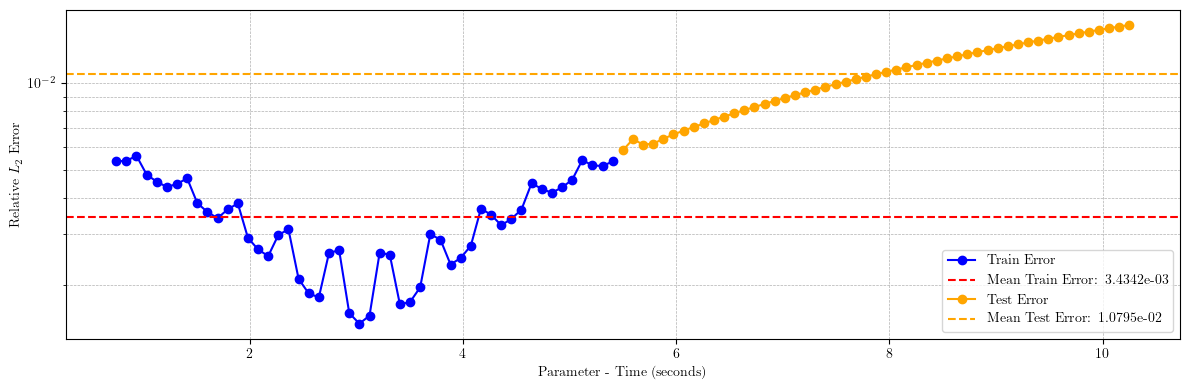

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(db_train.parameters_matrix, pred_train_errors, marker='o', linestyle='-', color='blue', label='Train Error')
plt.axhline(pred_train_mean, color='r', linestyle='--', label=f'Mean Train Error: {pred_train_mean:.4e}')
plt.plot(db_test.parameters_matrix, pred_val_errors, marker='o', linestyle='-', color='orange', label='Test Error')
plt.axhline(pred_val_mean, color='orange', linestyle='--', label=f'Mean Test Error: {pred_val_mean:.4e}')
plt.xlabel('Parameter - Time (seconds)')
plt.ylabel(r'Relative $L_2$ Error')
plt.yscale('log') 
plt.legend(loc='lower right')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [21]:
# Prediction errors for varying standard POD rank, for unregistered snapshots 
pod_ranks = [1, 2, 4, 8, 10, 16, 20, 25]
mean_train_errors = []
mean_test_errors = []

for rank in pod_ranks:
    standard_pod = POD(rank=rank)
    rbf = RBF()
    pod_rbf_rom = ROM(database=db_train, reduction=standard_pod, approximation=rbf)
    pod_rbf_rom.fit()

    train_err = pod_rbf_rom.test_error(db_train)
    test_err = pod_rbf_rom.test_error(db_test)
    
    mean_train_errors.append(train_err)
    mean_test_errors.append(test_err)

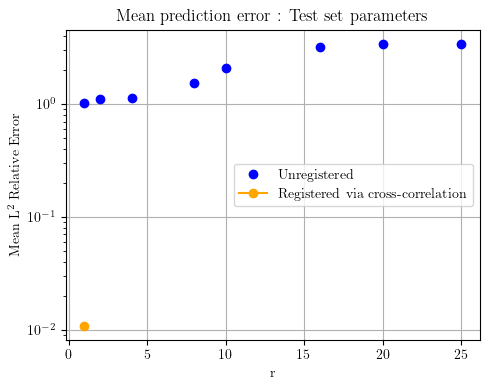

In [22]:
plt.figure(figsize=(5,4))
plt.plot(pod_ranks, mean_test_errors, marker='o', linestyle='', color='b', label='Unregistered')
plt.plot(1, pred_val_mean, marker='o', linestyle='-', color='orange', label = "Registered via cross-correlation")
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('Mean L$^2$ Relative Error')
plt.title("Mean prediction error : Test set parameters")
plt.grid(True)
plt.legend(loc="center right")
plt.tight_layout()
plt.show()